In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, ReLU, AveragePooling2D, \
    Dense, Concatenate, MaxPooling2D, Flatten


def conv_block(input_layer,
               filters,
               kernel_size):
    output_layer = Conv2D(filters=filters,
                          kernel_size=kernel_size,
                          padding='same',
                          use_bias=False,
                          kernel_initializer='he_normal')(input_layer)
    output_layer = BatchNormalization()(output_layer)
    return ReLU()(output_layer)


def inception_module(input_layer,
                     filters1x1,
                     filters3x3,
                     filters5x5):
    conv1x1 = conv_block(input_layer, filters1x1, (1, 1))

    conv3x3 = conv_block(input_layer, int(filters3x3 * 2 / 3), (1, 1))
    conv3x3 = conv_block(conv3x3, filters3x3, (3, 3))

    conv5x5 = conv_block(input_layer, int(filters5x5 * 3 / 4), (1, 1))
    conv5x5 = conv_block(conv5x5, filters5x5, (5, 5))

    pooling = AveragePooling2D(pool_size=(3, 3),
                               strides=(1, 1),
                               padding='same')(input_layer)
    pooling = conv_block(pooling, filters1x1, (1, 1))

    return Concatenate()([conv1x1, conv3x3, conv5x5, pooling])


def reduced_inception():
    input_layer = Input(shape=(28, 28, 1))

    output_layer = conv_block(input_layer, 16, (3, 3))
    output_layer = conv_block(output_layer, 16, (3, 3))
    output_layer = MaxPooling2D(pool_size=(3, 3),
                                strides=(2, 2))(output_layer)

    output_layer = inception_module(output_layer, 16, 32, 16)
    output_layer = inception_module(output_layer, 32, 64, 32)
    output_layer = MaxPooling2D(pool_size=(3, 3),
                                strides=(2, 2))(output_layer)

    output_layer = inception_module(output_layer, 32, 64, 32)
    output_layer = inception_module(output_layer, 64, 128, 64)
    output_layer = MaxPooling2D(pool_size=(3, 3),
                                strides=(2, 2))(output_layer)

    output_layer = conv_block(output_layer, 128, (1, 1))
    embedding = Flatten()(output_layer)

    predictions = Dense(units=128,
                        kernel_initializer='he_normal',
                        use_bias=False)(embedding)
    predictions = BatchNormalization()(predictions)
    predictions = ReLU()(predictions)

    predictions = Dense(units=10,
                        kernel_initializer='glorot_normal',
                        activation='softmax')(predictions)

    return Model(inputs=input_layer, outputs=predictions)


def pre_process(image):
    return (image / 127.5 - 1.0).reshape(28, 28, 1)


def to_one_hot_encoding(label):
    encoding = [0.0] * 10
    encoding[label] = 1.0
    return encoding


In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = [pre_process(image) for image in train_images]
test_images = [pre_process(image) for image in test_images]

train_labels = [to_one_hot_encoding(label) for label in train_labels]
test_labels = [to_one_hot_encoding(label) for label in test_labels]

model = reduced_inception()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 16)   144         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 28, 28, 16)   64          conv2d_14[0][0]                  
__________________________________________________________________________________________________
re_lu_14 (ReLU)                 (None, 28, 28, 16)   0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

model.fit(x=np.array(train_images),
          y=np.array(train_labels),
          validation_data=(np.array(test_images),
                          np.array(test_labels)),
          batch_size=128,
          validation_batch_size=1024,
          epochs=20)

Epoch 1/20
469/469 [==============================] - 15s 26ms/step - loss: 0.2962 - categorical_accuracy: 0.9110 - val_loss: 0.0537 - val_categorical_accuracy: 0.9825
Epoch 2/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0284 - categorical_accuracy: 0.9914 - val_loss: 0.0418 - val_categorical_accuracy: 0.9866
Epoch 3/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0197 - categorical_accuracy: 0.9939 - val_loss: 0.0455 - val_categorical_accuracy: 0.9859
Epoch 4/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0170 - categorical_accuracy: 0.9948 - val_loss: 0.0287 - val_categorical_accuracy: 0.9902
Epoch 5/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0132 - categorical_accuracy: 0.9959 - val_loss: 0.0471 - val_categorical_accuracy: 0.9846
Epoch 6/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0112 - categorical_accuracy: 0.9965 - val_loss: 0.0277 - val_categorical_accuracy:

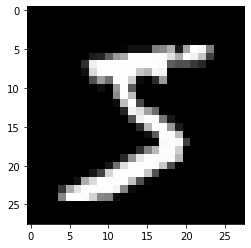

predicted label: 5
true label: 5


In [8]:
from matplotlib import pyplot as plt

image = (train_images[0] + 1.0) * 127.5
image = image.reshape(28, 28).astype(np.uint8)

plt.imshow(image, plt.cm.gray)
plt.show()

predicted_label = np.argmax(model.predict(np.array([train_images[0]]))[0])
true_label = np.argmax(train_labels[0])

print(f'predicted label: {predicted_label}')
print(f'true label: {true_label}')